In [1]:
import ref_index as RF
from os.path import exists
from jax import jit,grad,jacfwd,jacrev,value_and_grad
import matplotlib.pylab as plt
from scipy.interpolate import UnivariateSpline
#from jax.scipy.interpolate import 
from hapi import *
import requests as R
import numpy as np
import datetime as DT
import jax.numpy as jnp
from functools import partial
from os.path import expanduser
import pickle
import scipy.stats as stats
from scipy.interpolate import CubicSpline, RectBivariateSpline
%matplotlib widget
#


HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

In [2]:


@jit
def gauss(x, fwhm):
    twolog2=2*jnp.log(2.)
    sigma = fwhm/2./jnp.sqrt(twolog2)
    return (jnp.exp(-(x*x/2/sigma/sigma))/sigma/jnp.sqrt(2*jnp.pi))


Kb = 1.380649e-23  # J/K Boltzmans constant
h = 6.626176e-34  # Plancks constant
AMU = 1.6603145e-27
C = 299792458.  # m/s. Speed of light in vacuo


In [3]:
IR1=np.loadtxt('Datafiles/F-N-IR1-ABandCenter_transmission_air_6degr.dat',skiprows=1,unpack=True)
IR2=np.loadtxt('Datafiles/F-N-IR2-ABandTotal_air_6degr.dat',skiprows=1,unpack=True)
IR3=np.loadtxt('Datafiles/F-N-IR3-BgShort_transmission_air_6degr.dat',skiprows=1,unpack=True)
IR4=np.loadtxt('Datafiles/F-N-IR4-BgLong_transmission_air_6degr.dat',skiprows=1,unpack=True)
#convert from wavelength in air to wavelength in vacupe
grid = np.arange(12950, 13200, 0.002)
IR1[0,:]=RF.air2vac(IR1[0,:])
IR2[0,:]=RF.air2vac(IR2[0,:])
IR1[1,:]/=100
IR2[1,:]/=100
IR3[1,:]/=100
IR4[1,:]/=100
filter1=np.interp(grid, 1e7/IR1[0,-1::-1],IR1[1,-1::-1],left=0,right=0)
filter2=np.interp(grid, 1e7/IR2[0,-1::-1],IR2[1,-1::-1],left=0,right=0)
filters=np.vstack([filter1,filter2])

In [4]:
print("Before, figure default size is: ", plt.rcParams["figure.figsize"])
plt.rcParams["figure.figsize"] = (7, 5)
print("After, figure default size is: ", plt.rcParams["figure.figsize"])


Before, figure default size is:  [6.4, 4.8]
After, figure default size is:  [7.0, 5.0]


In [5]:
db_begin('Abanddata')
if not exists('./Abanddata/oxygen2.header'):

    fetch_by_ids('oxygen', [36], 1/776e-7, 1/749e-7)
c2 = 1.4387770  # CM K


Using Abanddata

oxygen
                     Lines parsed: 199

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: oxygen
  65536 bytes written to Abanddata/oxygen.data
Header written to Abanddata/oxygen.header
END DOWNLOAD
                     Lines parsed: 199
PROCESSED


In [6]:
url = "http://129.16.35.2:8080/msis/2019-02-02T12:00:00/70/130/120"
#url = "http://83.252.31.240:59059/msis/2019-06-20T12:00:00/80/130/150"
url = "http://129.16.35.2:8080/msis/2019-12-02T12:00:00/0/130/122"

atm = R.get(url).json()
N = np.array(atm['n2'])+np.array(atm['o2'])+np.array(atm['o'])
pres = N*Kb*atm['T']
atm['p'] = pres
z = np.array(atm['z'])
o2 = np.array(atm['o2'])/1e6  # to cm-3
T = atm['T']

def make_msis_atm (datetime,lat=0,lon=0, maxalt=121,minalt=0):
    urlbase="http://129.16.35.2:8080/msis/"
    url=urlbase+datetime.isoformat() + '/{}/{}/{}'.format(lat,lon,maxalt) 
    atm = R.get(url).json()
    N = np.array(atm['n2'])+np.array(atm['o2'])+np.array(atm['o'])
    pres = np.array(N*Kb*atm['T'])
    atm['p'] = pres
    z = np.array(atm['z'])
    o2 = np.array(atm['o2'])/1e6  # to cm-3
    T = np.array(atm['T'])
    return {"z":z[minalt:],"N":N[minalt:],"P":pres[minalt:],"O2":o2[minalt:],"T":T[minalt:]}

In [7]:
newatm=make_msis_atm(DT.datetime(2020,12,1,13),minalt=50)

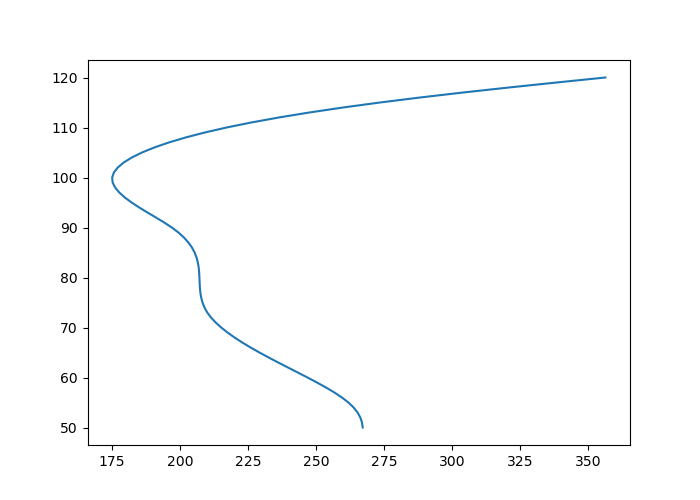

In [8]:
plt.figure()
plt.plot(newatm['T'],newatm['z'])

In [9]:
select('oxygen', ParameterNames=('nu', 'sw', 'local_iso_id', 'a', 'elower', 'gp', 'gpp'),
       Conditions=('==', 'global_upper_quanta', ('STR', ('       b      0'))),
       DestinationTableName='tmp')
nu, sw, iso, a, elow, gp, gpp = np.array(getColumns(
    'tmp', ['nu', 'sw', 'local_iso_id', 'a', 'elower', 'gp', 'gpp']))

for i in range(a.shape[0]):
    a[i] *= abundance(7, iso[i])
    sw[i] *= abundance(7, iso[i])
eup = elow+nu
1e8/min(nu), 1e8/max(nu), min(nu), max(nu)


(7756.231169079724, 7496.700669612073, 12892.859666, 13339.201391)

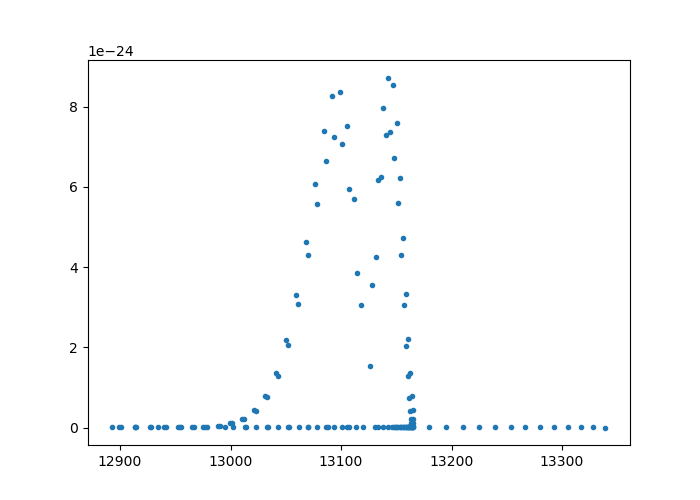

In [10]:
plt.figure()
plt.plot(nu, sw, '.')


In [11]:
Dfwhm = nu*2/C * np.sqrt(2*Kb*298.*np.log(2)/32/AMU)
Temps=np.linspace(100,600,501)
sigma = np.zeros([len(Temps), len(grid)])
emission = np.zeros([len(Temps), len(grid)])

for layer,Tlayer in enumerate(Temps):
    print('layer number = {}'.format(layer))
    Sjlayer = sw*298/Tlayer*np.exp(1.439*elow*(Tlayer-298)/298/Tlayer)
    intens = gp*a*np.exp(-c2*eup/Tlayer)*nu*nu
    intens /= intens.sum()
    DfwhmLayer = Dfwhm*np.sqrt(Tlayer/298.)
    for i in range(len(nu)):
        sigma[layer, :] += (Sjlayer[i]*gauss(grid-nu[i], DfwhmLayer[i]))
        emission[layer, :] += (intens[i]*gauss(grid-nu[i], DfwhmLayer[i]))
for i in range(emission.shape[0]):
    emission[i, :] /= emission[i, :].sum()


layer number = 0
layer number = 1
layer number = 2
layer number = 3
layer number = 4
layer number = 5
layer number = 6
layer number = 7
layer number = 8
layer number = 9
layer number = 10
layer number = 11
layer number = 12
layer number = 13
layer number = 14
layer number = 15
layer number = 16
layer number = 17
layer number = 18
layer number = 19
layer number = 20
layer number = 21
layer number = 22
layer number = 23
layer number = 24
layer number = 25
layer number = 26
layer number = 27
layer number = 28
layer number = 29
layer number = 30
layer number = 31
layer number = 32
layer number = 33
layer number = 34
layer number = 35
layer number = 36
layer number = 37
layer number = 38
layer number = 39
layer number = 40
layer number = 41
layer number = 42
layer number = 43
layer number = 44
layer number = 45
layer number = 46
layer number = 47
layer number = 48
layer number = 49
layer number = 50
layer number = 51
layer number = 52
layer number = 53
layer number = 54
layer number = 55
la

15879

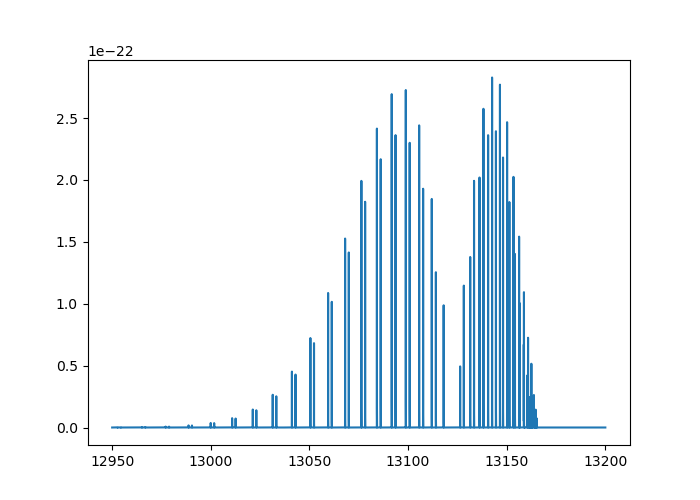

In [247]:
plt.figure()
plt.plot(grid,sigma[200,:])
nz=(emission[200,:]!=0)
nz.sum()


In [12]:
np.save('Datafiles/o2Abandsigma100-600', sigma.astype(float32))
np.save('Datafiles/o2Abandemission100-600', emission.astype(float32))


In [10]:
sigma=np.load('Datafiles/o2Abandsigma100-600.npy')
emission=np.load('Datafiles/o2Abandemission100-600.npy')

In [11]:
@partial(jit, static_argnums=3)
def path_z(z_top, z_t, sol_zen=90, nsteps=100):
    Re = 6375.  # km
    sol_zen /= 180/np.pi
    B = jnp.arcsin((Re+z_t) * jnp.sin(jnp.pi-sol_zen)/(Re+z_top))
    S_top = jnp.sin(sol_zen-B)*(Re+z_top)/jnp.sin(jnp.pi-sol_zen)

    Ret2 = (Re + z_t)**2
    step = S_top/nsteps
    S_top_half = S_top - step/2
    z_step = [jnp.sqrt(Ret2 + (S_top_half - i*step)**2 - 2*(Re + z_t) *
                      (S_top_half - i*step)*jnp.cos(jnp.pi-sol_zen))-Re for i in range(nsteps)]
    return (z_step, step)


In [12]:
filename = expanduser("~donal/projekt/SIW/MATS-analysis/Donal/retrievals/jacobianIR1IR2_500-620.pkl")
with open(filename, "rb") as file:
    [edges, k, ecef_to_local] = pickle.load(file)

In [13]:
@jit
def interpT(x,xs,ys):
    ix=jnp.floor(x-100).astype(int)
    return ((x-xs[ix-1])*ys[ix,:].T + (xs[ix]-x)*ys[ix-1,:].T)/(xs[ix]-xs[ix-1])

In [14]:
# VER = np.ones_like(T) 
# VER = 100*stats.norm.pdf(z,88,6.5)
# Temps=np.array(T)
# tanz=60
# def ir1fun(tanz,VER,Temps):
#        no_steps=200
#        Temps=jnp.array(Temps)
#        deltaz = np.diff(z).mean()       
#        z_paths, path_step = path_z(z[-1], tanz, 90.0, no_steps)
#        z_paths.extend(z_paths[-2::-1])
#        z_paths=jnp.array(z_paths)
#        zi = np.array(jnp.floor((z_paths-z[0])/deltaz),dtype=int)
#        Ti=jnp.array(jnp.floor(Temps[zi]-100),dtype=int)
#        tau = (sigma[Ti, :].T*(jnp.exp(jnp.interp(z_paths, z, jnp.log(o2))))
#               ).cumsum(axis=1)*path_step * 1e5
#        VERs=jnp.interp(z_paths, z, VER)
#        res=filters@(jnp.exp(-tau)*VERs*emission[Ti, :].T)
#        return res[0].sum()/res[1].sum()


In [15]:
startT= jnp.linspace(100,600,501)
interpT(jnp.array([300,350]),startT,sigma).shape

(125000, 2)

In [16]:
VER = np.ones_like(T) 
VER = 3e3*1e6*stats.norm.pdf(z,88,4.5)
Temps=np.array(T)
tanz=60

In [17]:

@jit
def ir1fun(tanz,atmos,atm):
       VER,Temps=atm
       z=atmos['z']
       o2=atmos['O2']
       no_steps=200
       Temps=jnp.array(Temps)
       startT= jnp.linspace(100,600,501)  
       deltaz = jnp.diff(z).mean()       
       z_paths, path_step = path_z(z[-1], tanz, 90.0, no_steps)
       #print(path_step)
       z_paths.extend(z_paths[-2::-1])
       z_paths=jnp.array(z_paths)
       zi = jnp.array(jnp.floor((z_paths-z[0])/deltaz),dtype=int)
       pathtemps=jnp.interp(z_paths,z,Temps)
       sigmas=interpT(pathtemps,startT,sigma)
       emissions=interpT(pathtemps,startT,emission)
       
       tau = (sigmas*(jnp.exp(jnp.interp(z_paths, z, jnp.log(o2))))
              ).cumsum(axis=1)*path_step * 1e5
       VERs=jnp.interp(z_paths, z, VER)*path_step*1e5
       res=filters@(jnp.exp(-tau)*VERs*emissions)
       return res[0].sum()

@jit
def ir2fun(tanz,atmos,atm):
       VER,Temps=atm
       z=atmos['z']
       o2=atmos['O2']
       no_steps=200
       Temps=jnp.array(Temps)
       startT= jnp.linspace(100,600,501)  
       deltaz = jnp.diff(z).mean()       
       z_paths, path_step = path_z(z[-1], tanz, 90.0, no_steps)
       z_paths.extend(z_paths[-2::-1])
       z_paths=jnp.array(z_paths)
       zi = jnp.array(jnp.floor((z_paths-z[0])/deltaz),dtype=int)
       pathtemps=jnp.interp(z_paths,z,Temps)
       sigmas=interpT(pathtemps,startT,sigma)
       emissions=interpT(pathtemps,startT,emission)
       
       tau = (sigmas*(jnp.exp(jnp.interp(z_paths, z, jnp.log(o2))))
              ).cumsum(axis=1)*path_step * 1e5
       VERs=jnp.interp(z_paths, z, VER)*path_step*1e5
       res=filters@(jnp.exp(-tau)*VERs*emissions)
       return res[1].sum()


In [18]:
ir1,[vergrad,tgrad]=value_and_grad(ir1fun,argnums=2)(90,atm,[VER,atm['T']])
print(ir1)
Temps2=Temps.copy()
Temps2[70]+=5


TypeError: Argument '2019-12-02T12:00:00' of type <class 'str'> is not a valid JAX type.

In [ ]:
vergrad.shape


NameError: name 'vergrad' is not defined

NameError: name 'tgrad' is not defined

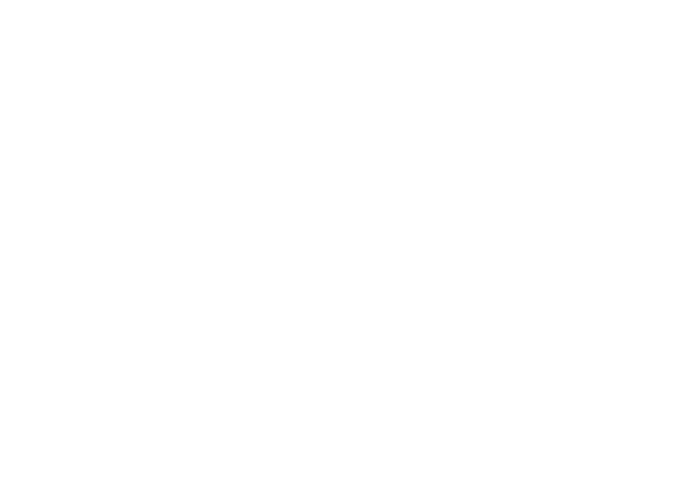

In [19]:
plt.figure()
plt.plot(tgrad)


In [20]:
tanheights=np.linspace(60,120,61)

# Setup start data and calculate K

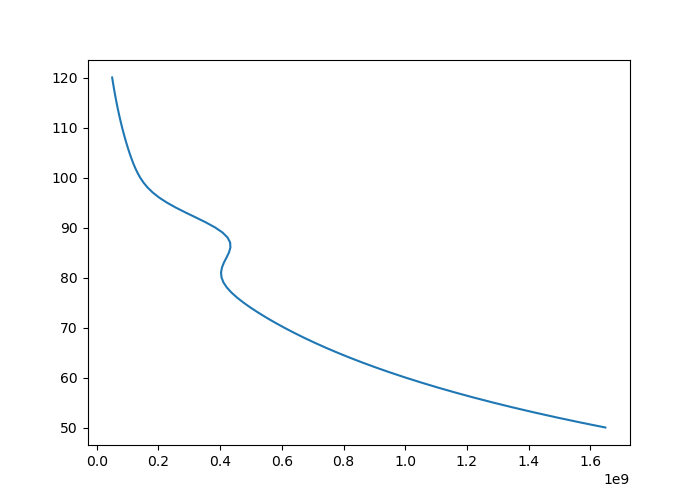

In [21]:
atm=make_msis_atm(DT.datetime(2020,12,1,13),minalt=50)
VER = np.ones_like(atm["T"]) 
VER = 2e3*1e6*stats.norm.pdf(atm['z'],88,4.5)+1e3*1e6 *exp(-(atm['z']-60)/20)
plt.figure()
plt.plot(VER,atm['z'])

In [22]:
ir1=np.zeros_like(tanheights)

vergrad1=np.zeros([len(tanheights),len(VER)])
tgrad1=np.zeros([len(tanheights),len(atm['T'])])
for iz,tanz in enumerate(tanheights):
    ir1[iz],[vergrad1[iz,:],tgrad1[iz,:]]=value_and_grad(ir1fun,argnums=2)(tanz,atm,[VER,atm['T']])

In [23]:

ir2=np.zeros_like(tanheights)
vergrad2=np.zeros([len(tanheights),len(VER)])
tgrad2=np.zeros([len(tanheights),len(atm['T'])])
for iz,tanz in enumerate(tanheights):
    ir2[iz],[vergrad2[iz,:],tgrad2[iz,:]]=value_and_grad(ir2fun,argnums=2)(tanz,atm,[VER,atm['T']])

Text(0, 0.5, 'Tangent altitude (km)')

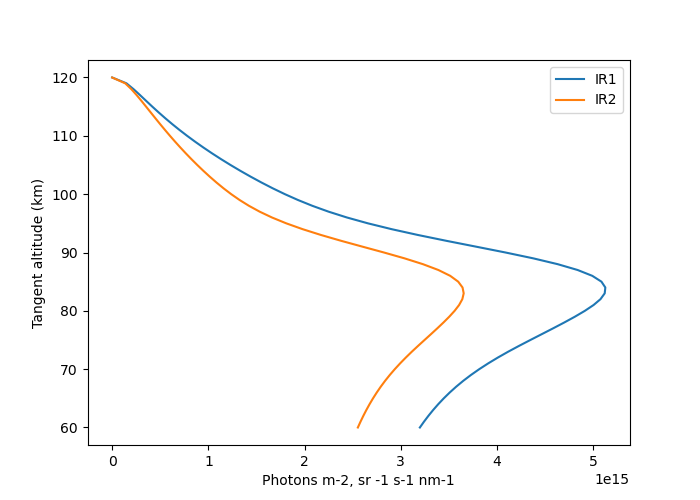

In [24]:
plt.figure()
plt.plot(ir1/3.57,tanheights,ir2/8.16,tanheights)
plt.legend(['IR1','IR2'])
plt.xlabel( 'Photons m-2, sr -1 s-1 nm-1')
plt.ylabel( 'Tangent altitude (km)')

# Make a new atmophere and generate test data

In [25]:
newatm=make_msis_atm(DT.datetime(2020,6,1,13),minalt=50)
newVER=4e3*1e6*stats.norm.pdf(newatm['z'],84,5.5)

In [51]:
ir1new=np.zeros_like(tanheights)
ir2new=np.zeros_like(tanheights)

for iz,tanz in enumerate(tanheights):
    ir1new[iz]=ir1fun(tanz,newatm,[newVER,newatm['T']])
    ir2new[iz]=ir2fun(tanz,newatm,[newVER,newatm['T']])

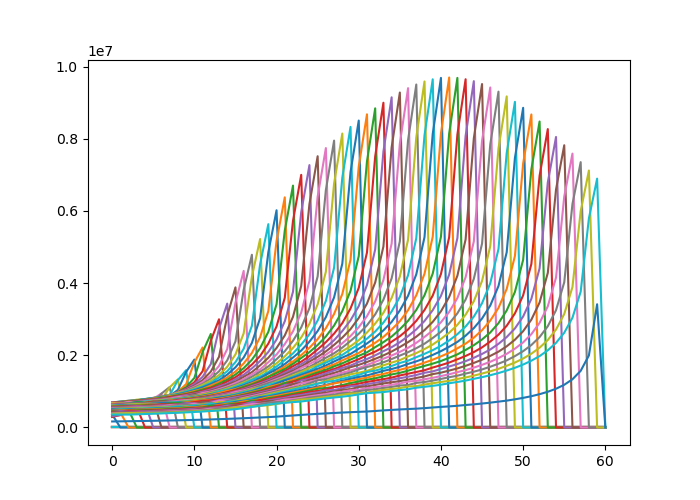

In [27]:
plt.figure()
plt.plot(vergrad1)


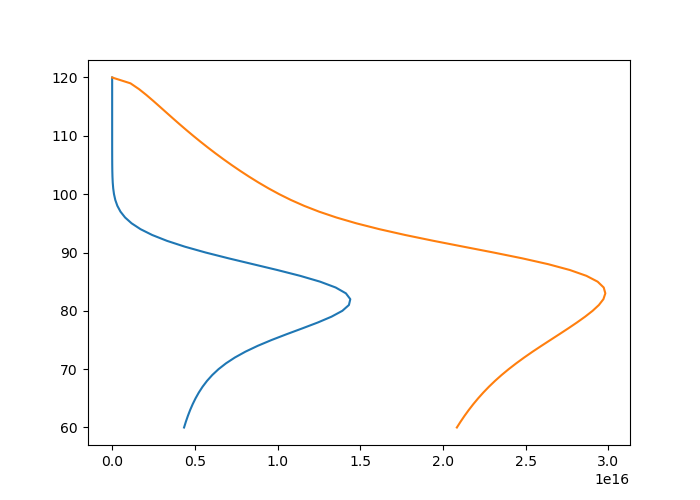

In [28]:
plt.figure()
plt.plot(ir2new,tanheights,ir2,tanheights)

In [29]:
measvec=np.hstack([ir1new,ir2new])
measvec.shape

(122,)

In [30]:
xvec=np.hstack([VER,atm['T']])
xvec.shape

(142,)

In [31]:
K=np.vstack([np.hstack([vergrad1,tgrad1]),np.hstack([vergrad2,tgrad2])])

In [32]:
K.shape

(122, 142)

In [33]:
test=K@xvec

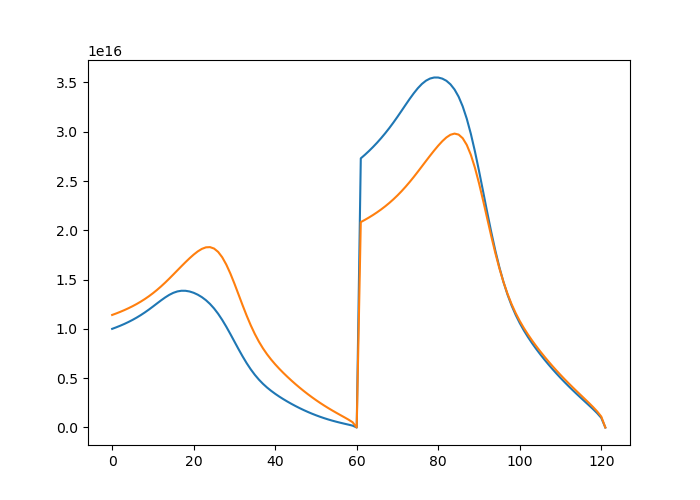

In [34]:
plt.figure()
plt.plot(test)
plt.plot(np.hstack([ir1,ir2]))



In [35]:
Sa_inv=np.diag(np.ones([xvec.shape[0]]),0).astype('float32') * (1/np.max(measvec)) /100
Se_inv=np.diag(np.ones([K.shape[0]]),0).astype('float32') * (1/np.max(measvec))
gamma=5

In [56]:
Sa_inv.shape

(142, 142)

In [40]:
x=np.hstack([VER,atm['T']])
ktSei=K.T @ Se_inv
S=np.linalg.inv((1+gamma)*Sa_inv + ktSei @ K)
xr=S @ (ktSei@(measvec-np.hstack([ir1,ir2])) - Sa_inv@(x-xvec))

In [41]:
xnew=x+xr

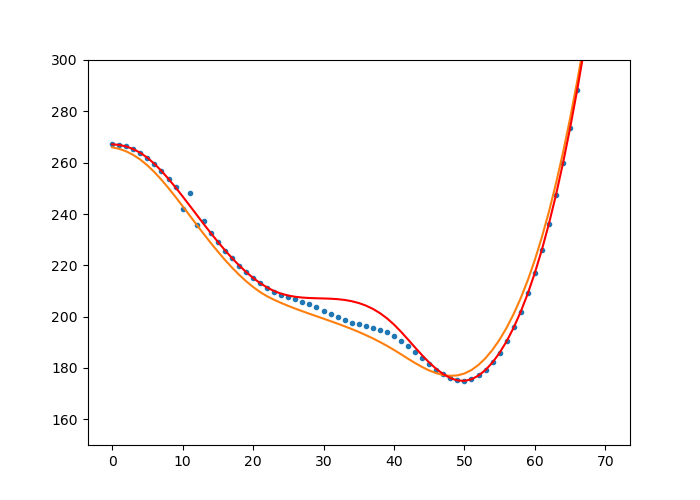

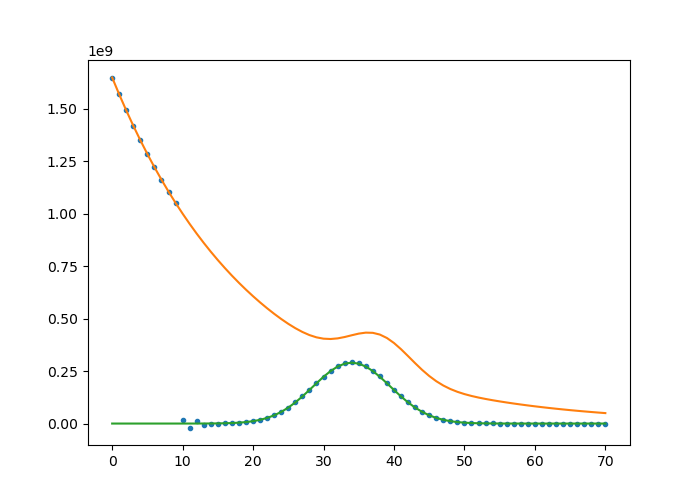

In [42]:
plt.figure()
plt.plot(xnew[71:],'.')
plt.plot(newatm['T'])
plt.plot(atm['T'],'r')
plt.ylim([150,300])
plt.figure()
plt.plot(xnew[:71],'.')
plt.plot(VER)
plt.plot(newVER)

In [48]:
xnew.shape
#newVER.shape

(142,)

In [50]:
for iz,tanz in enumerate(tanheights):
    ir1[iz]=ir1fun(tanz,newatm,[xnew[0:71],xnew[71:] ])
    ir2[iz]=ir2fun(tanz,newatm,[xnew[0:71],xnew[71:] ])

In [52]:
gamma=gamma/10
ktSei=K.T @ Se_inv
S=np.linalg.inv((1+gamma)*Sa_inv + ktSei @ K)
xr=S @ (ktSei@(measvec-np.hstack([ir1,ir2])) - Sa_inv@(x-xvec))
xnew=xnew+xr

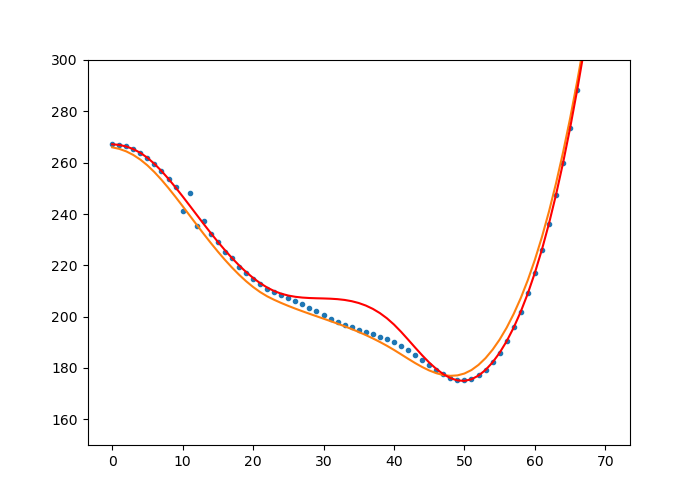

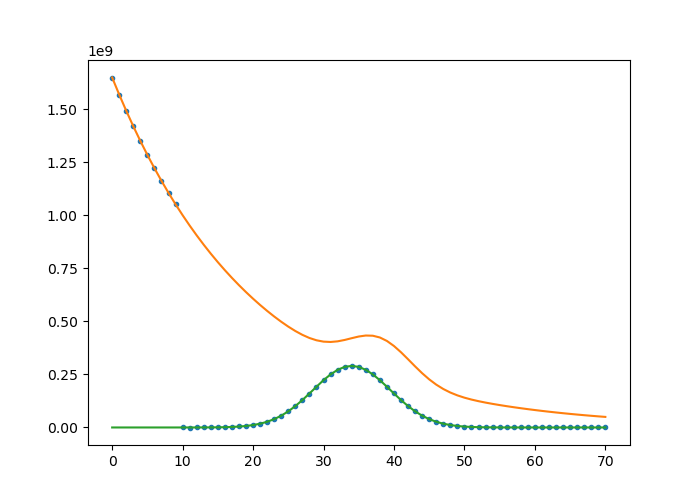

In [53]:
plt.figure()
plt.plot(xnew[71:],'.')
plt.plot(newatm['T'])
plt.plot(atm['T'],'r')
plt.ylim([150,300])
plt.figure()
plt.plot(xnew[:71],'.')
plt.plot(VER)
plt.plot(newVER)

# Test making 2-D a-priori 

In [9]:
import xarray as xa
msis=xa.load_dataset('Datafiles/msis_cmam_climatology_200.nc')


In [230]:
month=3
rs=(edges[0][0:-1]+edges[0][1::])/2
lat=60*np.ones(len(edges[2])-1)

Tarray=msis.T.sel(month=month).interp(lat=lat,z=((rs-localR)/1000))
o2array=msis.o2.sel(month=month).interp(lat=lat,z=((rs-localR)/1000))
VERarray=np.zeros_like(Tarray)


ValueError: operands could not be broadcast together with shapes (110,) (120,) 

In [227]:

VER = 2e3*1e6*stats.norm.pdf((rs-localR)/1000,88,4.5)+1e3*1e6 *exp(-((rs-localR)/1000-60)/20)

In [229]:
VER.shape

(110,)

In [207]:
len(edges[1])

2

In [12]:
atm['o2']

[5.020737956575879e+24,
 4.5840556781087325e+24,
 4.1587654170286065e+24,
 3.756219414930612e+24,
 3.383129692584194e+24,
 3.0426976247772697e+24,
 2.735560200641134e+24,
 2.460580351341869e+24,
 2.2154314812831773e+24,
 1.9970664189283836e+24,
 1.8020521963823327e+24,
 1.625326335318296e+24,
 1.4580159518368192e+24,
 1.29497570137803e+24,
 1.1351678825301883e+24,
 9.800672980704682e+23,
 8.332254506362171e+23,
 7.005510629385451e+23,
 5.8518480124239244e+23,
 4.875805923614009e+23,
 4.066519158638696e+23,
 3.403637932365735e+23,
 2.8593209918987203e+23,
 2.409850940448039e+23,
 2.0367858978275792e+23,
 1.7256831803203334e+23,
 1.4651521036047714e+23,
 1.2461469176133417e+23,
 1.0614337604805769e+23,
 9.05189027528324e+22,
 7.726934867790542e+22,
 6.600966956593545e+22,
 5.642373974467884e+22,
 4.826875664742517e+22,
 4.141302601387086e+22,
 3.564018365891798e+22,
 3.0759290469164895e+22,
 2.661637062515162e+22,
 2.308678250359105e+22,
 2.006911629987387e+22,
 1.7480551942752647e+22,
 

In [1]:
plt.figure()
np.log(msis.p.isel(month=5)).plot.contourf(y='z')

NameError: name 'plt' is not defined

In [17]:
msis

<xarray.Dataset>
Dimensions:  (z: 200, lat: 181, month: 12, lst: 15)
Coordinates:
  * z        (z) int64 0 1 2 3 4 5 6 7 8 ... 191 192 193 194 195 196 197 198 199
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lst      (lst) float64 2.0 4.25 4.75 5.25 5.75 ... 18.75 19.25 19.75 22.0
    plev     (lat, month, z) float64 9.915e+04 8.689e+04 ... 6.018e-05 5.833e-05
Data variables:
    o        (month, lat, z) float64 0.0 0.0 0.0 ... 3.728e+15 3.634e+15
    T        (month, lat, z) float64 261.5 257.3 252.4 ... 732.9 733.7 734.5
    date     (month) object '2008-01-15T00:00:00' ... '2008-12-15T00:00:00'
    n2       (month, lat, z) float64 2.166e+25 1.929e+25 ... 2.052e+15 1.964e+15
    o2       (month, lat, z) float64 5.81e+24 5.174e+24 ... 1.616e+14 1.539e+14
    p        (month, lat, z) float64 9.915e+04 8.689e+04 ... 6.018e-05 5.833e-05
    o3_vmr   (lat, month, z, lst) float64 8.973e-08 9.095e-08 ... 4.716e-15